**Municipality Budget Planning**


To analyse our problem we make use of several python packages, which we import in the code below.

In [1]:
#needed for matplotlib to function in notebook
%matplotlib inline

#import packages
import numpy as np
import pandas as pd
import pydst
from matplotlib import pyplot as plt
import scipy.stats
import tkinter as tk
import tkinter as tk

Dst = pydst.Dst(lang='en')

**Data sorting**

In order to examine our topic we retrieve data from the DST api. We get data from the tables REGK11, BUDK1 and INDAMP01.
we use REGK11 to get accounting data for all municipalities in Denmark. The data is registered at the end of the year. REGK11 covers the period 2011-2018.
BUDK1 is used to get budget data for all municipalities in Denmark. The data is registered at the beginning of the year and covers the period 2009-2019
We use INDAMP01 to get population data to examine our problem. the population is registered 1st of january and the table covers the period 2006-2017
We sort the api by imposing restrictions on the tables, e.g. price unit is set to pr. capita (1000 kr) for BUDK1 and REGK11.

further explain restrictions. note the dataframe names

In order to follow the data sorting and cleaning throughout the paper, we'll include account.head() to demonstrate the changes on the table

In [2]:
account = Dst.get_data(table_id = "REGK11", variables = {"OMRÅDE": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
budget = Dst.get_data(table_id = "BUDK1", variables = {"REGI07A": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
people = Dst.get_data(table_id = "INDAMP01", variables = {"OMRÅDE": ["*"], "KØN": ["TOT"], "ALDER": ["TOT"], "PERSG": ["IALT"], "Tid": ["*"], "BNØGLE": ["PER"]})

In [3]:
account.head()

,OMRÅDE,FUNK1,DRANST,ART,PRISENHED,TID,INDHOLD
0,Hillerød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,62180
1,Solrød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53166
2,Dragør,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53794
3,Gribskov,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,61529
4,Gentofte,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,54695


We have several columns in our data which have no use in our analysis. They are therefore dropped. Further, we rename the columns to get more appropiate names 

In [4]:
account.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
budget.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
people.drop(["KØN", "ALDER", "PERSG", "BNØGLE"], axis=1, inplace=True)

budget.rename(columns = {"REGI07A":"Municipality", "TID": "Year", "INDHOLD":"Budget"}, inplace = True)
account.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"Account"}, inplace = True)
people.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"People"}, inplace = True)

account.head()

,Municipality,Year,Account
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


Our three dataframes do not share the same dimensions and cannot be merged. We have to further clean the dataframes before we can make our analysis

In [6]:
budget.info()
account.info()
people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 888
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Budget          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 831
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Account         686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 1378
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
People          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


In order to make our dataframes comparable, we remove all entries for non-municipalies. We further restrict the time periods for our data to the period 2011-2017.

In [5]:
for val in ["Region", "Province", "All Denmark"]:
    for count, dataset in enumerate([people, budget, account]):
        rowstodrop = dataset.loc[lambda df: df["Municipality"].str.contains(val)].index
        dataset.drop(rowstodrop, axis=0, inplace=True)

a = []
for i in range(2011,2018):
    a.append(str(i))

budget = budget.loc[budget["Year"].isin(a)]
people = people.loc[people["Year"].isin(a)]
account = account.loc[account["Year"].isin(a)]


In [7]:
budget.info()
people.info()
account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 888
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Budget          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 1378
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
People          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 831
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Account         686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


As seen from the .info() our dataframes have the same dimensions and we are able to merge them. We do an outer merge in two stages. First we merge people and account as the partialmerge dataframe. We then merge partialmerge with budget.


In [8]:
partialmerge = pd.merge(people, account, how="outer", on=["Municipality", "Year"])
fullymerged = pd.merge(partialmerge, budget, how="outer", on=["Municipality", "Year"])
fullymerged.head()

,Municipality,Year,People,Account,Budget
0,Holbæk,2011,69521,61203,61099
1,Faxe,2011,35277,59814,59963
2,Kalundborg,2011,49088,66668,66307
3,Ringsted,2011,32890,61444,62650
4,Slagelse,2011,77442,63393,63924


Since we are interested in the surplus in municipality finances. We want to compute the surplus, which we define as the difference between the budgetted and actual net expenses. We add the column named surplus to our dataframe fullymerged.

in the .head() we chose to look at Aalborg municipality to verify the accuracy of the computation.

In [10]:
fullymerged["Surplus"] = fullymerged["Budget"]-fullymerged["Account"]
fullymerged[fullymerged["Municipality"]=="Aalborg"].head()

,Municipality,Year,People,Account,Budget,Surplus
63,Aalborg,2011,199188,61958,62758,800
161,Aalborg,2012,201142,64535,65523,988
259,Aalborg,2013,203448,60966,61530,564
390,Aalborg,2014,205809,60002,60343,341
488,Aalborg,2015,207805,60893,60157,-736


**Data Analysis**




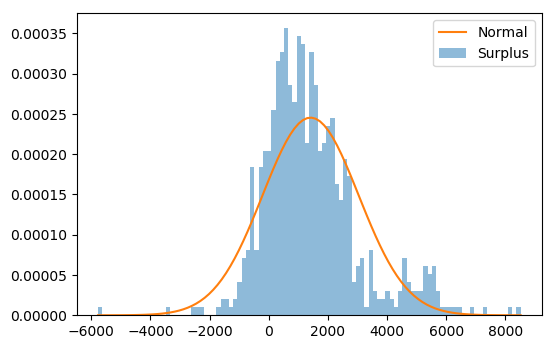

In [11]:
mean = np.mean(fullymerged["Surplus"])
variance = np.var(fullymerged["Surplus"])
sigma = np.sqrt(variance)

x = np.linspace(min(fullymerged["Surplus"]), max(fullymerged["Surplus"]), 100)


fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(fullymerged["Surplus"], density=True, bins = 100, alpha = 0.5, label = "Surplus")
ax.plot(x, scipy.stats.norm.pdf(x, mean, sigma), label = "Normal")
ax.legend()


It seems that there is no link between Surplus and people. 
we want to see if surplus is normal distributed. we see that this is not the case, but more like the municipalities tries to get a little surplus each year which is inefficient for the community.

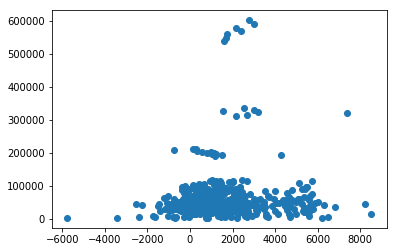

In [12]:
plt.scatter(fullymerged["Surplus"], fullymerged["People"])
plt.show()

In [14]:
from NokiaSnakeClient import graphwindow   

app = graphwindow(data=fullymerged, x="Year",y="Surplus",y2="People",graphnames="Municipality")
app.geometry("1280x720")
app.mainloop()